In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io

from smt.sampling_methods import LHS
from scipy.io import savemat

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:1


In [2]:
def true_1D_1(x): #True function for 1D_1 dy2/dx2 + dy/dx - 6y = 0; BC1: y(0)=2; BC2: dy/dx at (x=0) = -1;
    y = np.exp(2*x) + np.exp(-3*x)
    return y
    

In [3]:
label = "1D_SODE_tanh"
loss_thresh = 0.005

x = np.linspace(0,2,100).reshape(-1,1)

bc1_x = x[0].reshape(-1,1)
bc1_y = true_1D_1(x[0]).reshape(-1,1)
x_bc1_train = torch.from_numpy(bc1_x).float().to(device)
y_bc1_train = torch.from_numpy(bc1_y).float().to(device)
    

bc2_x = x[0].reshape(-1,1)
x_bc2_train = torch.from_numpy(bc2_x).float().to(device)
bc2_val = torch.tensor(-1.0,device=device)
bc2_val = bc2_val.view(1,1)

x_test = x.reshape(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().to(device)
y_true = true_1D_1(x_test)
y_true_norm = np.linalg.norm(y_true,2)

# Domain bounds
lb = np.array(x[0]) 
ub = np.array(x[-1]) 

In [4]:
def colloc_pts(N_f,seed):
    #Collocation Points
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,y)
    x01 = np.array([[0.0, 1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    
    x_coll_train = lb + (ub-lb)*sampling(N_f)
    x_coll_train = np.vstack((x_coll_train, bc1_x.reshape(-1,1))) # append training points to collocation points 

    return x_coll_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
    
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data) 
    
        self.beta = Parameter(torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
    
    'forward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)+ self.beta[:,i]*z*self.activation(z)
            
        a = self.linears[-1](a) 
         
        return a
    
    def forward_observe(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        mean_activs = np.zeros((len(layers)-1,))
        std_activs = np.zeros((len(layers)-1,))
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z) + self.beta[:,i]*z*self.activation(z)
            mean_activs[i] = torch.mean(self.linears[i].weight.data).cpu().detach().numpy()
            std_activs[i] = torch.std(self.linears[i].weight.data).cpu().detach().numpy()

            
        a = self.linears[-1](a) 
        mean_activs[-1] = torch.mean(self.linears[-1].weight.data).cpu().detach().numpy()
        std_activs[-1] = torch.std(self.linears[-1].weight.data).cpu().detach().numpy()
        
        
        return mean_activs, std_activs
                        
    def loss_BC1(self,x,y):
                
        loss_bc1 = self.loss_function(self.forward(x), y)
                
        return loss_bc1
    
    def loss_BC2(self,x_bc2,bc2_val):
        g = x_bc2.clone()             
        g.requires_grad = True
        y = self.forward(g)    
            
        y_x = autograd.grad(y,g,torch.ones([x_bc2.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        dy_dx = y_x[:,[0]]
        
        bc2 = dy_dx
        
        loss_bc2= self.loss_function(bc2,bc2_val)

        return loss_bc2
    
    def loss_PDE(self, x_coll,f_hat):
             
        g = x_coll.clone()             
        g.requires_grad = True
  
        y = self.forward(g) 

        y_x = autograd.grad(y,g,torch.ones([x_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        y_xx = autograd.grad(y_x,g,torch.ones(x_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        dy_dx = y_x[:,[0]]
        
        dy2_d2x = y_xx[:,[0]]
        
        f = dy2_d2x + dy_dx - 6*y
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    
    def loss(self,x_bc1,y_bc1,x_bc2,bc2_val,x_coll,f_hat):

        loss_bc1 = self.loss_BC1(x_bc1,y_bc1)
        loss_bc2 = self.loss_BC2(x_bc2,bc2_val)
        loss_f = self.loss_PDE(x_coll,f_hat)
        
        loss_val = loss_bc1 + loss_bc2 + loss_f
        
        return loss_val
          
    'test neural network'
    
    def test(self):
        y_pred = self.forward(x_test_tensor)
        y_pred = y_pred.cpu().detach().numpy()

        return y_pred
    
    def test_loss(self):
        y_pred = self.test()
        
        test_mse = np.mean(np.square(y_pred.reshape(-1,1) - y_true.reshape(-1,1)))
        test_re = np.linalg.norm(y_pred.reshape(-1,1) - y_true.reshape(-1,1),2)/y_true_norm
        
        return test_mse, test_re

In [6]:
def train_step(x_coll,f_hat):
    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(x_bc1_train,y_bc1_train,x_bc2_train,bc2_val,x_coll,f_hat)
        loss.backward()
        
        return loss

    optimizer.step(closure)

In [7]:
def data_update(loss_np):
    train_loss.append(loss_np)

    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [8]:
def train_model(max_iter,rep):
    print(rep) 
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    mean_activs = np.zeros((max_iter,len(layers)-1))
    std_activs = np.zeros((max_iter,len(layers)-1))
    
    grads = []
    for i in range(len(layers-1)):
        grads.append([])
    
    for i in range(max_iter):
        x_coll = torch.from_numpy(colloc_pts(N_f,i*11)).float().to(device)
        f_hat = torch.zeros(x_coll.shape[0],1).to(device)
        train_step(x_coll,f_hat)
        mean_activs[i,:],std_activs[i,:] = PINN.forward_observe(x_test_tensor[-1])
        
        loss_np = PINN.loss(x_bc1_train,y_bc1_train,x_bc2_train,bc2_val,x_coll,f_hat).cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1       
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
        
        for k in range(len(layers) - 1):
            grads[k].append((PINN.linears[k].weight.grad).cpu().detach().numpy())
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))
    
    return mean_activs,std_activs,grads

In [9]:
max_reps = 1
max_iter = 200

N_f = 1000

train_loss_full = []
test_mse_full = []
test_re_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

for reps in range(max_reps):
    
    train_loss = []
    test_mse_loss = []
    test_re_loss =[]
    
    'Generate Training data'
    torch.manual_seed(reps*36)
     #Total number of collocation points 
    
    
    layers = np.array([1,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers
    PINN = Sequentialmodel(layers)
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.25, 
                              max_iter = 10, 
                              max_eval = 15, 
                              tolerance_grad = 1e-5, 
                              tolerance_change = 1e-5, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')
   

    start_time = time.time()
    mean_activs,std_activs,grads = train_model(max_iter,reps)

    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
 
    
    print('Training time: %.2f' % (elapsed_time[reps]))

mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full, "test_re_loss": test_re_full, "Time": elapsed_time, "label": label, "Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 4.539222 Test MSE 383.8337102563185 Test RE 0.9986979066404411
1 Train Loss 3.5665226 Test MSE 381.60592609825386 Test RE 0.9957954503899816
2 Train Loss 2.4127002 Test MSE 380.3217129419256 Test RE 0.994118469978402
3 Train Loss 2.38287 Test MSE 381.0137035961305 Test RE 0.995022452101

In [ ]:
a = 0
for i in range(10):
    a = a + test_re_full[i][-1]
print(a/10)

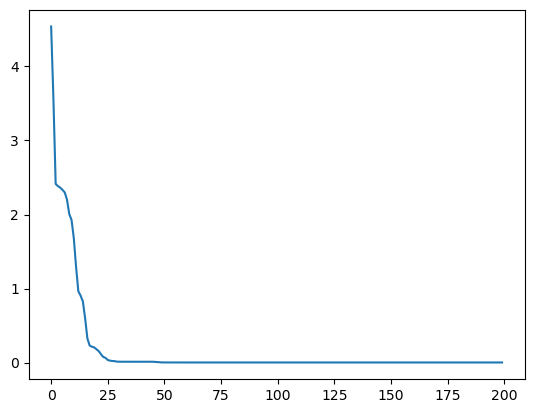

In [10]:
plt.plot(np.array(train_loss_full).reshape(-1,))

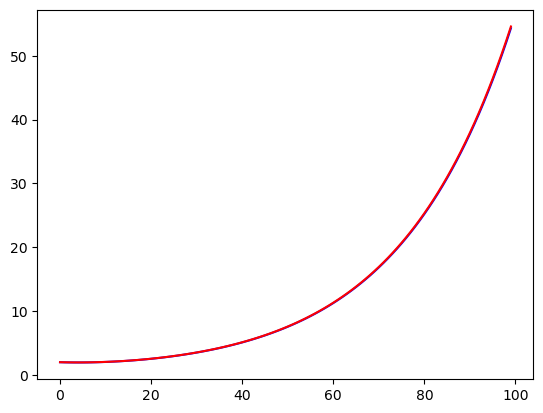

In [11]:
plt.plot(PINN.forward(x_test_tensor).cpu().detach().numpy(),'b')
plt.plot(y_true,'r')

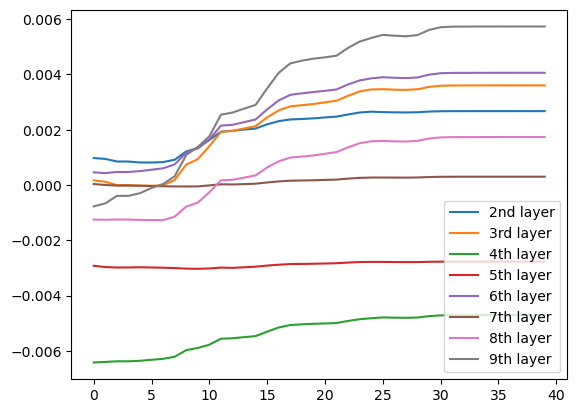

In [12]:

max_steps = 40
# plt.plot(mean_activs[:max_steps,0],label = '1st layer')
plt.plot(mean_activs[:max_steps,1],label = '2nd layer')
plt.plot(mean_activs[:max_steps,2],label = '3rd layer')
plt.plot(mean_activs[:max_steps,3],label = '4th layer')
plt.plot(mean_activs[:max_steps,4],label = '5th layer')
plt.plot(mean_activs[:max_steps,5],label = '6th layer')
plt.plot(mean_activs[:max_steps,6],label = '7th layer')
plt.plot(mean_activs[:max_steps,7],label = '8th layer')
plt.plot(mean_activs[:max_steps,8],label = '9th layer')
# plt.plot(mean_activs[:,4],label = '1st layer')
plt.legend()

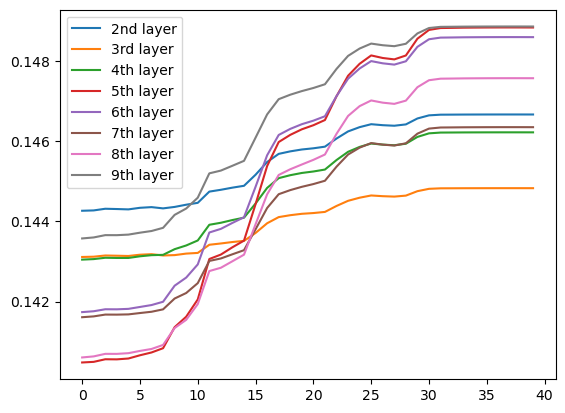

In [13]:
max_steps = 40
# plt.plot(mean_activs[:max_steps,0],label = '1st layer')
plt.plot(std_activs[:max_steps,1],label = '2nd layer')
plt.plot(std_activs[:max_steps,2],label = '3rd layer')
plt.plot(std_activs[:max_steps,3],label = '4th layer')
plt.plot(std_activs[:max_steps,4],label = '5th layer')
plt.plot(std_activs[:max_steps,5],label = '6th layer')
plt.plot(std_activs[:max_steps,6],label = '7th layer')
plt.plot(std_activs[:max_steps,7],label = '8th layer')
plt.plot(std_activs[:max_steps,8],label = '9th layer')
# plt.plot(std_activs[:max_steps,9],label = '10th layer')
# plt.plot(mean_activs[:,4],label = '1st layer')
plt.legend()

In [25]:
grads1 = np.zeros((200,))
for i in range(200):
    grads1[i] = np.std(grads[5][i][:])

(0.0, 4.0)

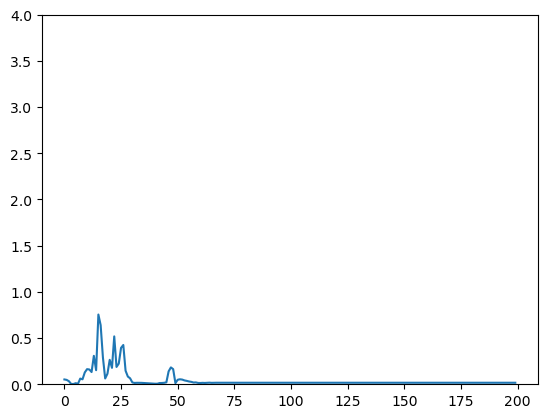

In [26]:
plt.plot(grads1)
plt.ylim([0,4])